---
title: Implementing Perceptron 
author: Daniela Delgado
date: '2024-05-14'
image: "image.jpg"
description: "In this blog post, I completed an implementation of the perceptron algorithm and tested it in several experiments. I implemented simple perceptron and minibatch perceptron.
objectives: 
  - Theory
  - Implementation
  - Experimentation"
format: html
---

In [1]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Perceptron implementation 
[perceptron.py file](https://github.com/ddelgado8090/ddelgado8090.github.io/blob/main/posts/implementing-perceptron/perceptron.py)

# Abstract
In this blog post, I implement perceptron. Then, through experiments working with 2d linearly separable data, 2d non-linearly separable data, and working in more than 2 dimensions, I was able to test the implementation and see the different ways the evolution of the loss function during training changed at each experiment. In the 2d linearly separable data experiment, I noticed the data was linearly separable through the visualization of the data points, and saw how it reached a loss of 0.0, which is what we wanted to see if the data is linearly separable. When I tested the 2d non-linearly separable data, the results were the opposite of the linearly separable data as the points had no clear separation when visualized and the graph showing the evolution of the loss over training illustrated how it never reached 0.0 loss in the 1000 iterations. In other words, if there was no limit, it would keep running. Finally, in experimenting with more than 2 dimensions, I was able to see that the algorithm could still reach a 0.0 loss and be linearly separable. In this blog post, I took away how to implement perceptron and the best ways to use and apply it.

## Implementation of perceptron.grad()

For my perceptron.grad() function, I wrote the following code: 

        def grad(self, X, y):

                s = X @ self.w.T
                
                # this return does same as return torch.where((y * s) < 0, y@X, 0.0)
                
                return ((y * X) * (s * y < 0))

Here, I begin by setting the score to be the product of X matrix-multiplied by the transpose of w as given in the instructions to compute $s_i = \langle \mathbf{w}, \mathbf{x}_i\rangle$. Then, I return the gradient which is (y multiplied by X) and then multiplied by s times y if it is less than 0. This is the same as the equation: $\mathbb{1}\left[s_i y_{i} < 0 \right] y_{i} \mathbf{x}_{i}$. If s*y is greater than zero, then the boolean tensor would return False and it would be set to zero, thus making the entire thing return zero. Otherwise, it returns a gradient calculation.


### Testing the perceptron.py file with a Minimal Training Loop

In the training loop, we will repeat the procedure for a specified number of times (or until convergence).

This was taken from the perceptron lecture notes:

In [2]:
import torch
torch.manual_seed(12345)


def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y
X, y = perceptron_data(n_points = 300, noise = 0.2)


Now, we will plot the data to visualize if it is linearly separable. 

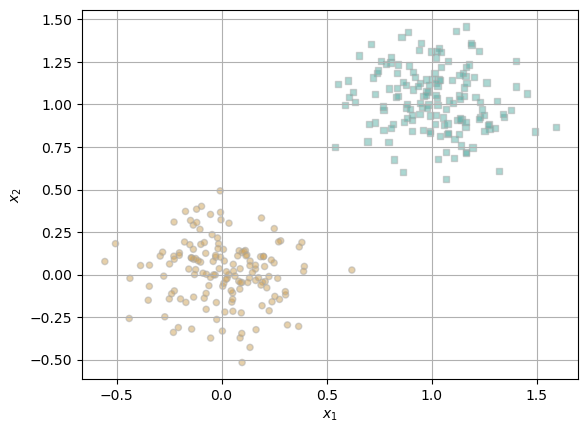

In [3]:
from matplotlib import pyplot as plt

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)
plt.grid(True)

As we can see, the data points are linearly separable as the circle points are on the lower left while the square points are on the upper right of the graph.

Finally, we will check if the code is working by running the “minimal training loop” code taken from the perceptron lecture notes and see if it will eventually achieve loss = 0 on linearly separable data:

In [4]:
# instantiate a model and an optimizer
p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0 : # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y)
    loss_vec.append(loss)
    # pick a random data point
    i = torch.randint(n, size = (1,))
    
    x_i = X[[i],:]
    y_i = y[i]
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)


/Users/ddelgado/CS451/ddelgado8090.github.io/posts/implementing-perceptron/perceptron.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_f7fb22vcd9/croot/pytorch-select_1700447874772/work/aten/src/ATen/native/TensorShape.cpp:3618.)
  scores = (X@self.w.T)


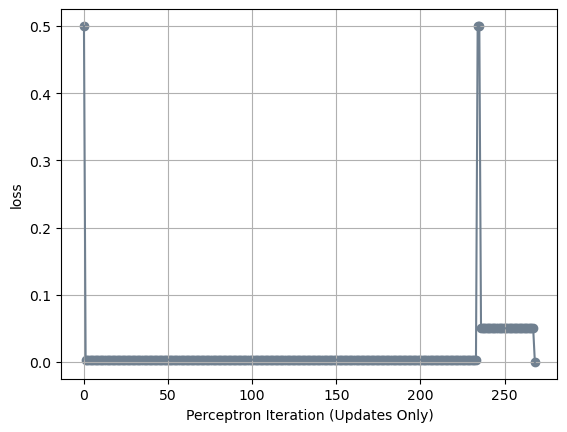

In [5]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.grid(True)

As we can see with the graph, the data is linearly separable as the loss reaches 0, demonstrating a perfect training accuracy.

## Part B: Experiments
### Experiment 1: 

Using 2d data like the data in the example above, if the data is linearly separable then the perceptron algorithm converges to weight vector w describing a separating line (provided that the maximum number of iterations is large enough).
 
Taken from my Logistic Regression blog post where I edited Phil's code from the notes, this code creates classification data with noise and the second function creates the graph to show the classification_data through a graph. There are 300 points graphed where the x-axis (x_1) is a number you can measure and the y-axis (x_2) is another feature vector:

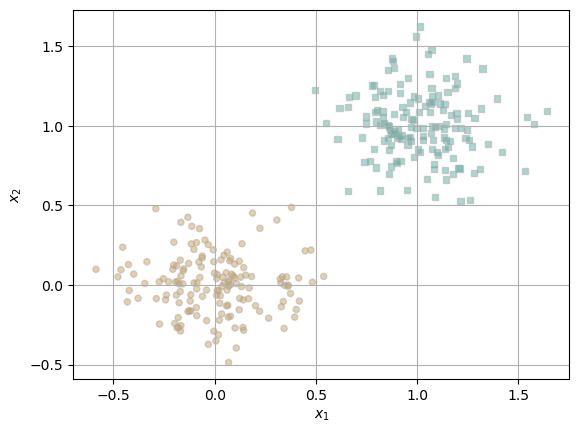

In [6]:
def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + -torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plt.grid(True)
plot_perceptron_data(X, y, ax)

Here, we see the data is linearly separable as the circle points are on the lower left while the square points are on the upper right of the graph.

Now, we will show the separating line through the points:

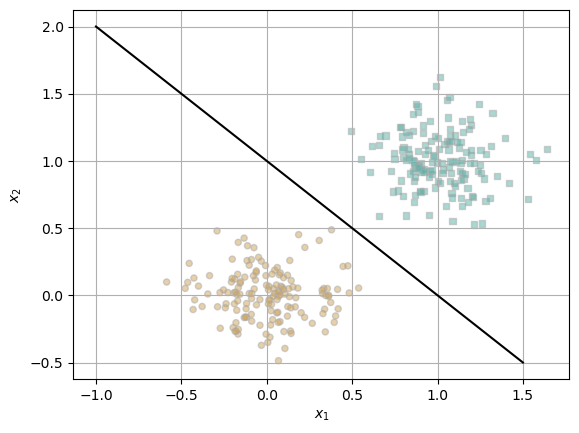

In [7]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)

w_1 = torch.Tensor([1,  1, -1]) 

draw_line(w_1, x_min = -1, x_max = 1.5, ax = ax, color = "black")
plt.grid(True)

The line above effectively separates the points with the line being drawn right between the points.

Next, we will see the evolution of the loss function during training. This was taken from Phil's perceptron notes: 

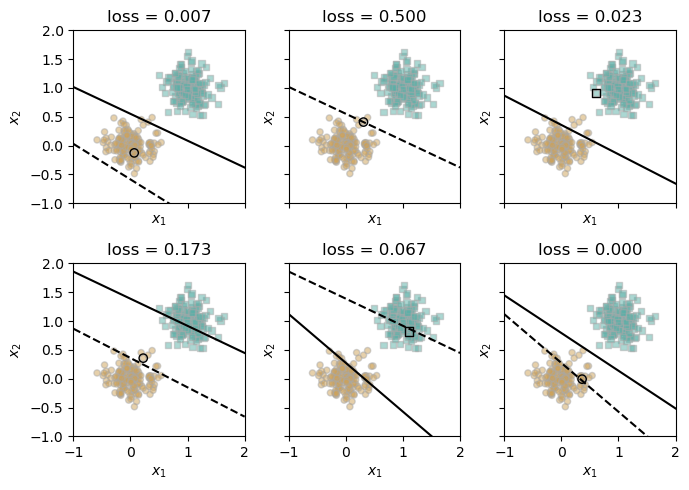

In [8]:
torch.manual_seed(123456)

# initialize a perceptron
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []
while loss > 0:

    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value
    i = torch.randint(n, size = (1,))
    
    x_i = X[[i],:]
    y_i = y[i]
    # perform a perceptron update using the random data point
    local_loss = opt.step(x_i, y_i)

    if local_loss > 0:
        #ax.clear()
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
        #current_ax = min(5, current_ax + 1)
plt.tight_layout()


As seen by the graphs, the loss reaches zero, proving the data is linearly separable and demonstrating a perfect accuracy score.

### Experiment 2:

In this second experiment, we will explore when data is not linearly separable.

First, we make points where the circles and squares are mixed within each other by increasing the noise:

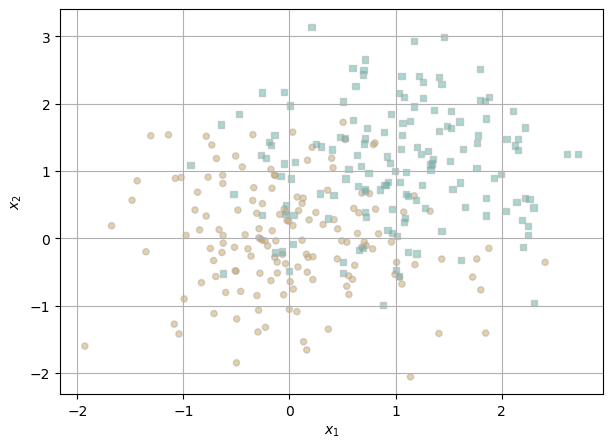

In [9]:
torch.manual_seed(12345)

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data(noise = 0.8)
plot_perceptron_data(X, y, ax)
plt.grid(True)

Next, we attempt to draw the line with a maximum iteration of 1000. If we do nt give it this maximum number of iterations, the code will keep running trying to find the line that linearly separates the points, which =, as we can see, will not be possible.

In [10]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)


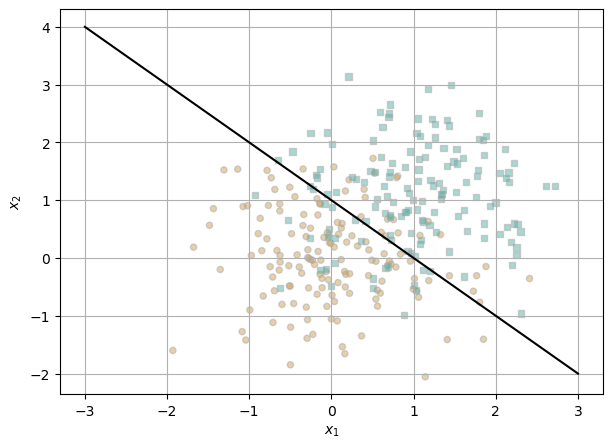

In [11]:
# instantiate a model and an optimizer
p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0
# for keeping track of loss values
loss_vec = []

n = X.size()[0]

num_iter = 1000
while loss > 0 and num_iter > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress
    loss = p.loss(X, y)
    loss_vec.append(loss)
    # print(loss)
    # pick a random data point
    i = torch.randint(n, size = (1,))
    
    x_i = X[[i],:]
    y_i = y[i]
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    num_iter = num_iter - 1

fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)

draw_line(w_1, x_min = -3, x_max = 3, ax = ax, color = "black")
plt.grid(True)


Here, we see the the data is not linearly separable as the points are scattered within each other on either side of the line.

To see the evolution of loss over time, I create the following graph:

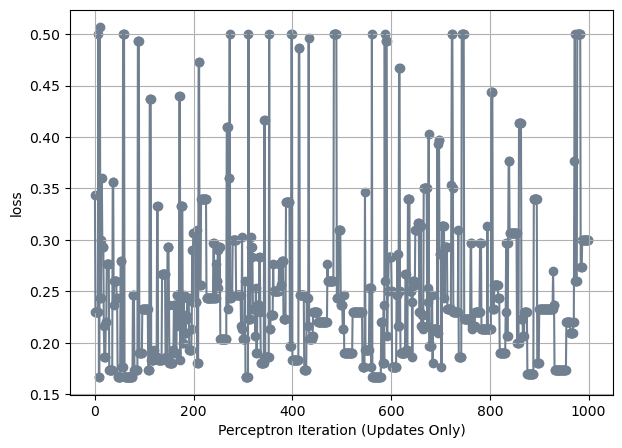

In [12]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.grid(True)

The graph above demonstrates the evolution of the loss over training. As seen, it never reaches 0.0 in the 1000 iterations, so if there was no limit, it would keep running.

### Experiment 3: 
Here, I run algorithm on data with at least 5 features instead of 2:

In [13]:

X, y = perceptron_data(n_points = 300, noise = 0.5, p_dims=5)

# instantiate a model and an optimizer
p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0 : # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress
    loss = p.loss(X, y)
    loss_vec.append(loss)
    # pick a random data point
    i = torch.randint(n, size = (1,))
    
    x_i = X[[i],:]
    y_i = y[i]
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)


Next, I will show the evolution of the score over the training period: 

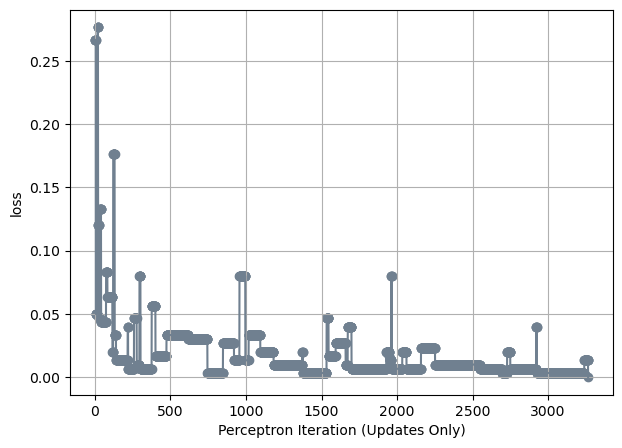

In [14]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.grid(True)

Given the data above, I believe the data is linearly separable as the code is set to terminate when it reaches 0, which, as we can see, it does.

# Part C: Minibatch Perceptron

The mini-batch perceptron algorithm computes an update using k points at once, rather than a single point. Thus, instead of calling the perceptron.step() function, I will call the newly made step function I made for this experiment called the mini_step() that also takes in the newly made gradient function called mini_grad() which accepts a submatrix of the feature matrix X. 

### Minibatch gradient implementation:

The mini_grad implementation works by calculating the score in the same way as the regular gradient function: the score is the product of X matrix-multiplied by the transpose of w as given in the instructions to compute $s_i = \langle \mathbf{w}, \mathbf{x}_i\rangle$. Then, I reshape the score and the target vector y to be column vectors to avoid shape errors. Finally, I do the same gradient calculation as the original one where the equation is $\mathbb{1}\left[s_i y_{i} < 0 \right] y_{i} \mathbf{x}_{i}$. If s*y is greater than zero, then the boolean tensor would return False and it would be set to zero, thus making the entire thing return zero. Otherwise, it returns a gradient calculation.

The “minimal training loop” code used in the previous experiments to check if it is working and see if it will eventually achieve loss = 0 on linearly separable data is also used here, but with an edit to be able to get a random submatrix of the feature matrix X and target vector y:


In [15]:
torch.manual_seed(123456)

def mini_batch(k):   
    # instantiate a model and an optimizer
    p = Perceptron()
    opt = PerceptronOptimizer(p)

    loss = 1.0

    # for keeping track of loss values
    loss_vec = []

    n = X.size()[0]

    while loss > 0 : # dangerous -- only terminates if data is linearly separable
        
        # not part of the update: just for tracking our progress
        loss = p.loss(X, y)
        loss_vec.append(loss)
        # pick a random data point
        i = torch.randint(n, size = (1,))
        
        #k = 10
        ix = torch.randperm(X.size(0))[:k]
        x_batch = (X[ix,:])
        y_batch = (y[ix])
        # perform a perceptron update using the random data point
        opt.mini_step(x_batch, y_batch)
    return loss_vec

## Minibatch Perceptron Experiments

### Experiment 1:
When k = 1, minibatch perceptron performs similarly to regular perceptron:

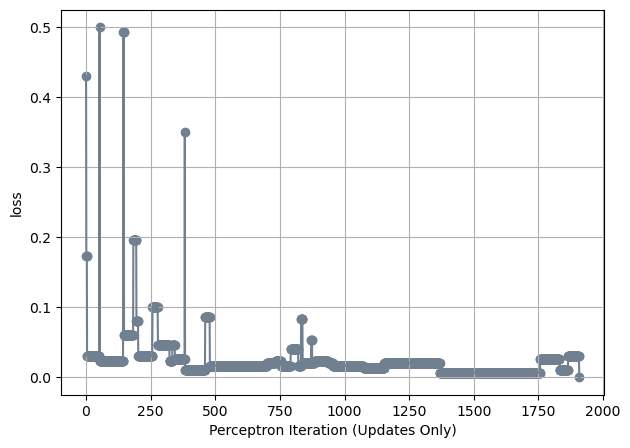

In [16]:
loss_vec = mini_batch(k=1)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.grid(True)

As we can see, the evolution of the score over the training period looks similar to the regular perceptron evolution graph, specifically it forms similar to the third experiment where we ran it with  moe than two dimensions.

## Experiment 2: 
When k = 10, minibatch perceptron can still find a separating line in 2d.

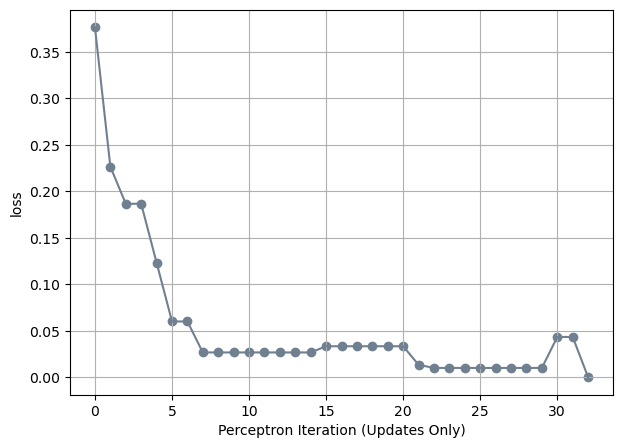

In [17]:
loss_vec = mini_batch(k=10)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.grid(True)

Here, we see how the algorithm can still find a separating line as the evolution of the score over the training period reaches a loss=0.

## Experiment 3:
When k = n (that is, the batch size is the size of the entire data set), minibatch perceptron can converge even when the data is not linearly separable, provided that the learning rate alpha is small enough

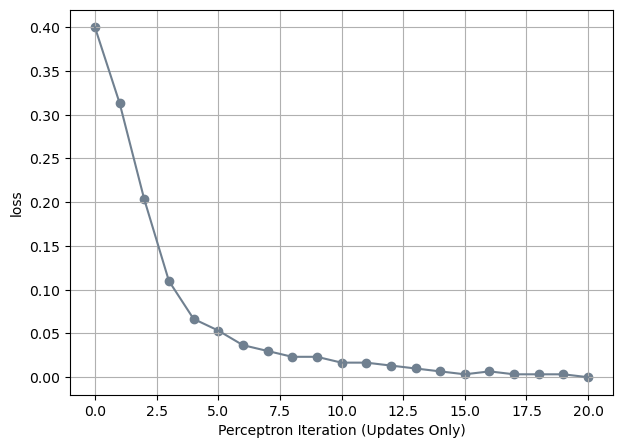

In [18]:
loss_vec = mini_batch(k=X.size()[0]) # k = n(num of points in data set)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.grid(True)

As seen, the data still converges and gets a loss=0 even when the data is not linearly separable.

## Runtime Complexity

What is the runtime complexity of a single iteration of the perceptron algorithm? Does the runtime complexity of a single iteration depend on the number of data points n? What about the number of features p? If you implemented minibatch perceptron, what is the runtime complexity of a single iteration of the minibatch perceptron algorithm?

- The runtime complexity of a single iteration of the perceptron algorithm is O(n * p) because n, the number of data points, and p, the number of features, both make up the computational time. Therefore, the runtime complexity of a single iteration does depend on the number of data points n and the number fo features p because the algorithm iterates through each data point once to update the weights on misclassifications, creating the runtime of O(n), and for ech data point it also calculates the matrix multiplication of X and w, thus creating the runtime of O(p).

- The runtime complexity of a single iteration of the minibatch perceptron algorithm is based on k, the size of the minibatch, and the number of features p, thus it has a runtime of O(k*p). In a singe iteration, the algorithm goes through a "minibatch" of data points rather than processing the entire dataset. Thus, it is now based on k, the size of the minibatch, instead of n as it processes k points at each iteration. Furthermore, it is still based on the number of features p because the algorithm iterates through each data point in the minibatch once to update the weights.


# Conclusion

In this blog post, I learned how to implement the perceptron algorithm, both the regular and the minibatch algorithms. I was able to see the different ways the algorithm works and in what situations the data can be linearly separable or not. I also learned what sets of features influence if the algorithm is able to find a decision boundary. Through experiments with 2d linearly separable data, 2d non-linearly separable data, and working in more than 2 dimensions (five in this case), I was able to test the implementation and see the different ways the evolution of the loss function during training changed at each experiment. Furthermore, I was able to understand the algorithm more through the implementation of the minibatch perceptron algorithm. This implementation helped me see what was truly happening behind the scenes by setting a smaller size of data to look at and editing the code to work with that. Overall, I was able to gain a more nuanced understanding of what this algorithm does and how it works. 